## Polished Code (Simulated Data Example)

### Coordinate Descent Algorithm with Elastic Net Regularization

#### Samir D Patel

This notebook is an overview of my own implementation of an an Elastic Net Regularized, Coordinate Descent Algorithm on a simulated (randomly generated) dataset.

This was done as part of my DATA 558 Machine Learning course at the University of Washington.

In [2]:
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt  
import pandas as pd
import copy
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from multiprocessing import Pool

# Only needed for IPython Notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [66]:
# Importing the "Hitters" dataset from Introduction to Statistical Learning and standardizing the predictors

def load_data():
    """
    This function loads the 'Hitters' dataset from Introduction to Statistical
    Learning, splits the responses and predictors into X and Y respectively
    and standardizes both X and Y.

    :return X: numpy array
        Data containing the predictors
    :return Y: numpy array
        Data containing the response

    """
    np.random.seed(0)
    X_create = np.random.normal(loc = 1, scale = 1, size = (1, 100))
    eps = np.random.normal(loc=0, scale=0.01,size = 100)
    beta_c = np.array([0,1,2,3])

    Y = (beta_c[0] + beta_c[1]*X_create + beta_c[2]*(X_create**2) + beta_c[3]*(X_create**3) + eps).T
    Y = np.ravel(Y)

    #Matrix of predictors
    X = np.vstack([X_create**i for i in range(1, 4)]).T

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Y = scaler.fit_transform(Y)

    return X, Y


In [77]:


def init_vars(x_data):
    """
    This function takes the X dataset (predictors) as an argument and returns
    variables containing number of columns rows, and an initialization vector 
    of beta values for the coordinate descent algorithm.

    :param x_data: numpy array
        Data containing the predictors
    :return n: numpy array
        Data containing the number of observations/rows
    :return p: numpy array
        Data containing the number of predictors/columns
    :return beta_zero: numpy array
        A vector of zero values for initializing 'beta' in 
        the coordinate descent algorithm

    """

    n = x_data.shape[0]
    p = x_data.shape[1]
    beta_zero = np.zeros(p)

    return n, p, beta_zero


def partial_min(j, beta, alpha, lamb, x_data, y_data):
    """
    The function computes the solution to the partial minimization 
    problem for the L1-regularized component of the Elastic Net

    :param j: int
        Value of predictor column selected for descent
    :param beta: numpy array
        A vector of the beta coefficients used as input to calculate the 
        minimization of Beta at coordinate j
    :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty.
    :param lamb:  float
        Value of regularization penalty to apply to model
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
    :return new_beta: numpy array
        A vector of the updated beta coefficients after the minimization of 
        Beta at coordinate j

    """

    x = copy.deepcopy(x_data)
    y = copy.deepcopy(y_data)
    p = len(x[0])
    n = len(x)

    # Split of X dataset's column j
    x0j = np.delete(x, j, 1)

    # Remaining X dataset without column j
    xij = pd.DataFrame(x)[j]

    # Beta vector deleting entry with value j
    beta_0j = np.delete(beta, j)

    c = 0.5 * (1 / n) * 2 * np.sum(np.dot(xij.T, (y - np.dot(x0j, beta_0j))))
    a = 0.5 * (1 / n) * 2 * np.sum(xij ** 2, axis=0) + 0.5 * 2 * lamb * (1 - alpha)

    if c < -lamb * alpha:
        new_beta = (c + (lamb * alpha)) / a
    elif c > lamb * alpha:
        new_beta = (c - (lamb * alpha)) / a
    else:
        new_beta = 0

    return new_beta


def computeobj(beta, alpha, lamb, x_data, y_data):
    """
    This function computes the objective function for any Beta coefficient 
    vector, with arguments for alpha, lamb and the X and Y data.

    :param beta: numpy array
        A vector of the beta coefficients used as input
    :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty. 
    :param lamb:  float
        Value of regularization penalty to apply to model
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
    :return obj: float

    """

    x = copy.deepcopy(x_data)
    y = copy.deepcopy(y_data)
    n = len(x)

    obj = 0.5 * (1 / n) * (np.sum((y - np.dot(x, beta)) ** 2)) + 0.5 * lamb * (1 - alpha) * np.sum(
        np.abs(beta) ** 2) + lamb * alpha * np.sum(np.abs(beta))

    return obj


def cycliccoorddescent(beta, alpha, lamb, x_data, y_data, max_iter=1000, eps=1e-7):
    """
    This function implements the cyclic coordinate descent algorithm. 
    The function takes as input the initial point and the maximum number of iterations. 
    The stopping criterion is the maximum number of iterations or convergence criterion 'eps',
    whichever comes first.

    :param beta: numpy array
        A vector of the beta coefficients used as input
    :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty.
    :param lamb:  float
        Value of regularization penalty to apply to model
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
    :param max_iter: int
        Value for setting the maximum number of iterations in the algorithm
    :param eps: float
        Value used as a convergence criterion to end the algorithm once the
        coordinate descent between iterations becomes too low.
    :return beta_out: float
        The final calculated value of beta coefficients which minimizes
        the objective function.
    """

    x = copy.deepcopy(x_data)
    y = copy.deepcopy(y_data)
    p = len(x[0])
    new_beta = copy.deepcopy(beta)
    beta_out = [beta]

    t = 0

    # Value set to prevent early convergence
    bdelta = 9999

    while t < (max_iter * p) and bdelta > eps:
        j = np.remainder(t, p)
        new_beta[j] = partial_min(j, new_beta, alpha, lamb, x, y)
        if np.remainder(t, p) == 0:
            beta_out.append(np.array(new_beta))
            if t > 3:
                bdelta = np.abs(np.linalg.norm(beta_out[-2]) - np.linalg.norm(beta_out[-1]))
        t += 1

    return beta_out


def pickcoord(p):
    """
    This function randomly samples from the set {1...d} to select a 
    coordinate in the random cyclic descent algorithm.

    :param p: int
        Number of predictors in the dataset 
    :return pick: int
        The randomly chosen predictor use for coordinate descent
    """

    pick = np.random.randint(p)

    return pick


def randcoorddescent(beta, alpha, lamb, x_data, y_data, max_iter=1000, eps=1e-7):
    """
    This function implements the random coordinate descent algorithm. 
    The function takes as input the initial point and the maximum number of iterations. 
    The stopping criterion is the maximum number of iterations or convergence criterion 'eps',
    whichever comes first.

    :param beta: numpy array
        A vector of the beta coefficients used as input
    :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty.
    :param lamb:  float
        Value of regularization penalty to apply to model
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
    :param max_iter: int
        Value for setting the maximum number of iterations in the algorithm
    :param eps: float
        Value used as a convergence criterion to end the algorithm once the
        coordinate descent between iterations becomes too low.
    :return beta_out: float
        The final calculated value of beta coefficients which minimizes
        the objective function.

    """

    x = copy.deepcopy(x_data)
    y = copy.deepcopy(y_data)
    p = len(x[0])
    new_beta = copy.deepcopy(beta)
    beta_out = [beta]

    t = 0

    # Value set to prevent early convergence
    bdelta = 9999

    while t < (max_iter * p) and bdelta > eps:
    #while t < (max_iter * p):
        # for i in range(p):
        j = pickcoord(p)
        new_beta[j] = partial_min(j, new_beta, alpha, lamb, x, y)
        if np.remainder(t, p) == 0:
            beta_out.append(np.array(new_beta))
            if t > 3:
                bdelta = np.abs(np.linalg.norm(beta_out[-2]) - np.linalg.norm(beta_out[-1]))
        t += 1

    return beta_out


def runsklelasticnetcv(alpha, x_data, y_data, descent_type):
    """
    This function runs Sci-Kit Learn's ElasticNetCV running the coordinate
    descent algorithm with cross-validation to select optimal lambda 
    (regularization penalty). Function takes  input of alpha, predictor and 
    response data, and descent type ('cyclic' or 'random')

     :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty. 
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
     :param descent_type: str
        Selection of the coordinate descent algorithm type, either 'random'
        or 'cyclic
    :return betaskl: list of float values
    :return lambskl: float

    """

    encv = ElasticNetCV(l1_ratio=alpha, fit_intercept=False, tol=0.000001,
                        selection=descent_type, max_iter=10000)
    encv.fit(x_data, y_data)
    lambskl = encv.alpha_
    betaskl = encv.coef_

    return betaskl, lambskl


def runsklelasticnet(lamb, alpha, x_data, y_data, descent_type):
    """
    This function runs Sci-Kit Learn's ElasticNet function, running the 
    coordinate descent algorithm with input of lambda, alpha, predictor and 
    response data, and descent type ('cyclic' or 'random')
    (regularization penalty).

     :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty. 
    :param lamb:  float
        Value of regularization penalty to apply to model
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
     :param descent_type: str
        Selection of the coordinate descent algorithm type, either 'random'
        or 'cyclic
    :return betaskl: list of float values
    :return lambskl: float

    """

    en = ElasticNet(alpha=lamb, l1_ratio=alpha, fit_intercept=False,
                    selection=descent_type, tol=0.000001, max_iter=10000)
    en.fit(x_data, y_data)
    betaskl = en.coef_

    return betaskl


def cross_val(lamb_list, folds, x_data, y_data):
    """
    This function performs cross-validation for the hand-implemented
    coordinate descent algorithms.

    :param lamb_list: list of float values
        Values for regularization penalty to be used for cross validation.
    :param folds:  int
        Number of folds for K-Folds Cross Validation
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
    :return mse_list: list of float values
        List output of mean-squared error values from cross-validation
        for each lambda value, taking the the average of fold results.

    """

    X = np.array(x_data)
    Y = np.array(y_data)
    beta = beta_zero
    mse_list = []

    kf = KFold(n_splits=folds, random_state=None, shuffle=False)

    for lamb in lamb_list:

        mse_fold = []

        for train_index, test_index in kf.split(X):
            # Performing data split for fold
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            Y_train = Y_train.reshape((len(Y_train), 1))
            Y_test = Y_test.reshape((len(Y_test), 1))

            # Standardization of data after split
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            Y_train = scaler.fit_transform(Y_train)
            Y_test = scaler.transform(Y_test)
            Y_train = np.ravel(Y_train)
            Y_test = np.ravel(Y_test)

            # Running cyclic coord descent and calculating MSE
            beta_temp = cycliccoorddescent(beta, 0.9, lamb, x_data=X_train, y_data=Y_train)
            beta = beta_temp[-1]  # updating beta for warm start
            y_hat = np.dot(X_test, beta_temp[-1].T)
            mse_fold.append(mean_squared_error(Y_test, y_hat))

        mse_list.append(np.mean(mse_fold))

    return mse_list


def runcompareCV(lamb_list, alpha, folds, X_data, Y_data):
    """
    This function compares results between the hand-implemented and 
    SKLearn versions of the coordinate descent alg w/ Elastic Net regularization.

    :param lamb_list: list of float values
        Values for regularization penalty to be used for cross validation.
    :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty. 
    :param folds:  int
        Number of folds for K-Folds Cross Validation
    :param X_data: numpy array
        Data containing the predictors
    :param Y_data: numpy array
        Data containing the response
    :return data:  Pandas DataFrame
        Data object containing the cross validation results.
    :return skoptlamb: float
        Optimal value of lambda (regularization penalty term) determined
        by SKLearn
    :return myoptlamb: float
        Optimal value of lambda (regularization penalty term) determined
        by hand-implemented algorithm.

    """

    # Running hand implemented algorithm with cross-validation
    cv_mse = cross_val(lamb_list, folds, X_data, Y_data )

    # Running SKLearn algorithm with cross-validation
    encv = ElasticNetCV(alphas=lamb_list, l1_ratio=alpha, fit_intercept=False, max_iter=10000)
    encv.fit(X_data, Y_data)
    skl_lambs = encv.alphas_
    skl_mse = np.mean(encv.mse_path_, axis=1)
    skoptlamb = encv.alpha_

    # Creating dataframe with results
    data = pd.DataFrame()
    data['Lambda'] = lamb_list
    data['Cyclic MSE'] = cv_mse
    data['SKL Lambda'] = encv.alphas_[::-1]
    data['SKL MSE'] = skl_mse[::-1]
    data['Log Lambdas'] = np.log(lamb_list)
    
    # Calculating optimal lambda from hand impelmented results
    opt_lamb = np.ravel(data[data['Cyclic MSE'] == data['Cyclic MSE'].min(0)]['Lambda'])
    opt_lamb = opt_lamb[0]

    return data, skoptlamb, opt_lamb


def cvplot(data):
    """
    This function creates a plot based on the cross-validation results
    comparing the hand-implemented and SKLearn algorithms across varying
    regularization penalty values.
    
    :param data: Pandas DataFrame
        Data object containing cross-validation comparison from runcompareCV

    """

    # Plotting results of cross-validation comparison
    plt.figure(figsize=(30, 10));
    plt.plot(data['Log Lambdas'], data['Cyclic MSE'], label="Cyclic");
    plt.plot(data['Log Lambdas'], data['SKL MSE'], 'o', label="SKLearn_ELCV");
    plt.legend();
    plt.ylabel("Mean Squared Error", fontsize=30);
    plt.xlabel("Log Lambdas", fontsize=30);
    plt.title("Log Lambda vs Mean Squared Error from Cross Validation", fontsize=40);
    plt.xticks(fontsize=30);
    plt.yticks(fontsize=30);
    plt.legend(fontsize=30);

    
def calc_obj_val(beta_vals, alpha, lamb, x_data, y_data):
    """
    This function calculates a list of objective values across the 
    iterations of the coordinate descent algorithm.

    :param beta_vals: numpy array
        A vector of the beta coefficients used as input
    :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty. 
    :param lamb:  float
        Value of regularization penalty to apply to model
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
    :return obj_vals: list of float values
        The calculated objective function values throughout the coordinate
        descent (across all iterations)

    """

    obj_vals = []

    for i in range(len(beta_vals)):
        objv = computeobj(beta_vals[i], alpha, lamb, x_data, y_data)
        obj_vals.append(objv)

    return obj_vals


def objvals(alpha, lamb, x_data, y_data, beta_cyc_vals, beta_rand_vals):
    """
    This function outputs the list of objective values for hand-implemented
    cyclic and random coordinate descent algorithms, along with iteration
    counts for each.

    :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty. 
    :param lamb:  float
        Value of regularization penalty to apply to model
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
    :param beta_cyc_vals: numpy array
        Beta coefficient vectors for the iterations from the cyclic coordinate descent
    :param beta_rand_vals: numpy array
        Beta coefficient vectors for the iterations from the random coordinate descent
    :return cyc_obj_vals: list of float values
        The calculated objective function values throughout the cyclic
        coordinate descent (across all iterations)
    :return rand_obj_vals: list of float values
        The calculated objective function values throughout the random
        coordinate descent (across all iterations)

    """
    
    cyc_obj_vals = calc_obj_val(beta_cyc_vals, alpha, lamb, x_data, y_data)
    rand_obj_vals = calc_obj_val(beta_rand_vals, alpha, lamb, x_data, y_data)

    t_cyc_count = np.arange(len(cyc_obj_vals))
    t_rand_count = np.arange(len(rand_obj_vals))

    return cyc_obj_vals, rand_obj_vals, t_cyc_count, t_rand_count


def objvalsplot(alpha, lamb, x_data, y_data, beta_cyc_vals, beta_rand_vals):
    """
    This function creates a plot of the objective values vs iteration counts
    for hand-implemented cyclic and random coordinate descent algorithms 

    :param alpha: float
        Value for controlling the ElasticNet's L1_ratio where alpha = 0 is a full
        L2 penalty and alpha = 1 is a full L1 penalty.  Values between represent a
        combination of L1 and L2 penalty. 
    :param lamb:  float
        Value of regularization penalty to apply to model
    :param x_data: numpy array
        Data containing the predictors
    :param y_data: numpy array
        Data containing the response
    :param beta_cyc_vals: numpy array
        Beta coefficient vectors for the iterations from the cyclic coordinate descent
    :param beta_rand_vals: numpy array
        Beta coefficient vectors for the iterations from the random coordinate descent

    """

    # Calculating objective values and iteration counts for cyclic and random
    cyc_obj_vals, rand_obj_vals, t_cyc_count, t_rand_count = objvals(alpha, lamb, x_data, 
                                                                     y_data, beta_cyc_vals, beta_rand_vals)

    # Plotting results of objective values across iteration for cyclic and random
    plt.figure(figsize=(15, 7));
    plt.plot(t_cyc_count, cyc_obj_vals, label="Cyclic");
    plt.plot(t_rand_count, rand_obj_vals, "+", label="Random");
    plt.legend();
    plt.ylabel("Objective Value", fontsize=20);
    plt.xlabel("Iteration Count (t)", fontsize=20);
    plt.title("Iteration Count (t) vs Objective Values", fontsize=25);
    plt.xticks(fontsize=20);
    plt.yticks(fontsize=20);
    plt.legend(fontsize=20);


### EXAMPLE 1: "Hitters" data set (real world example)

##### The example we will go through uses a dataset from the real-world, "Hitters", from Introduction to Statistical Learning 

###### Loading the pre-processed dataset

In [78]:
X, Y = load_data()

C:\Users\Samir\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Samir\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


###### Initialization of variables

In [79]:
n, p, beta_zero = init_vars(X)

###### Creating list of lambda (regularization penalty) values to use for cross-validation.

In [80]:
lamb_list = [10**k for k in range(-7, 7)]

###### Running own implementation of cross-validation using K-Folds method and comparing to the cross-validation results of _ElasticNetCV_ from Sci-Kit Learn

In [81]:
cvdata, skopt, myoptlamb = runcompareCV(lamb_list, 0.9, 3, X, Y)

In [82]:
print(' ')
print('Optimal Lambda (Regularization parameter) - My Cyclic Coordinate Descent with Elastic Net after Cross Validation')
print(' ')
print(myoptlamb)

 
Optimal Lambda (Regularization parameter) - My Cyclic Coordinate Descent with Elastic Net after Cross Validation
 
1e-05


###### Calculation and comparison of objective values vs iteration count for both hand implemented cyclic and random coordinate descent algorithms.

In [83]:
beta_cyc_opt = cycliccoorddescent(beta_zero, 0.9, myoptlamb, X, Y, max_iter = 300)
print(' ')
print('Beta Coefficients - My Cyclic Coordinate Descent with Elastic Net using Optimal Lambda')
print(' ')
print(beta_cyc_opt[-1])


 
Beta Coefficients - My Cyclic Coordinate Descent with Elastic Net using Optimal Lambda
 
[ 0.03607304  0.17866758  0.79507307]


In [84]:
beta_rand_opt = randcoorddescent(beta_zero, 0.9, myoptlamb, X, Y, max_iter = 300)
print(' ')
print('Beta Coefficients - My Random Coordinate Descent with Elastic Net using Optimal Lambda')
print(' ')
print(beta_rand_opt[-1])


 
Beta Coefficients - My Random Coordinate Descent with Elastic Net using Optimal Lambda
 
[ 0.01199575  0.0012578   0.99856505]


#### Plot of objective values across the iterations of the cyclic and random descent algorithms 

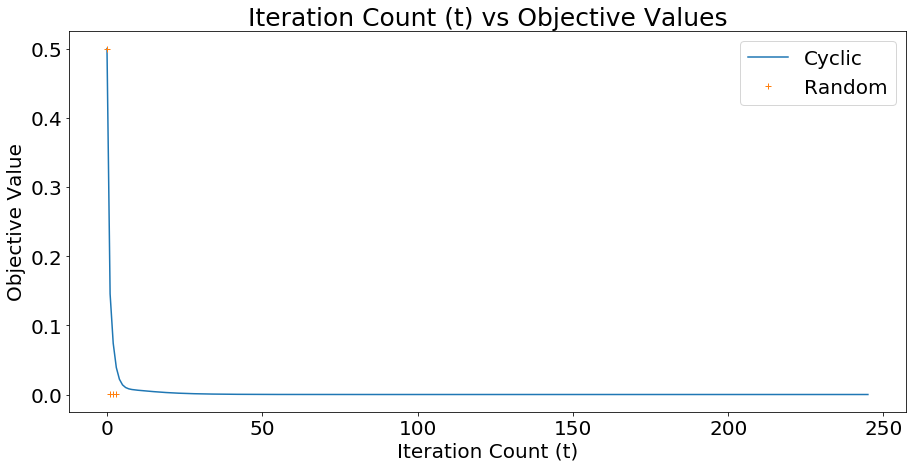

In [85]:
objvalsplot(0.9, myoptlamb, X, Y, beta_cyc_opt, beta_rand_opt)

#### From the results above, we see that convergence happens relatively quickly for both the cyclic and random coordinate descent algorithms which also line up reasonably well in respect to one another.